# Convolutional Neural Network on CIFAR-100 Dataset
Author: **Tien Dinh**

## Introduction
This is a model built using Tensorflow. The model was trained on the CIFAR-100 Dataset for 5000 times. I was able to get around 50% of accuracy, which is pretty reasonable since the data has only 500 images per class.

### Reference
* [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.

**First we are going to get the data and prepare it for training**

In [1]:
CIFAR_DIR = 'cifar-100-python/'

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['meta', 'test', 'train']

In [4]:
all_data = [0, 1, 2]

In [5]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [6]:
meta_data = all_data[0]
test_data = all_data[1]
train_data = all_data[2]

In [7]:
meta_data.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

In [8]:
test_data.keys()

dict_keys([b'batch_label', b'filenames', b'coarse_labels', b'fine_labels', b'data'])

**Using matplotlib to visualize the images**

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [10]:
test_data[b'data'].shape

(10000, 3072)

In [11]:
X = test_data[b'data']

In [12]:
X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')

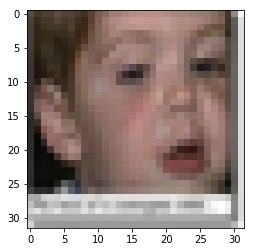

In [13]:
plt.imshow(X[1012])

In [14]:
X[0].max()

255

In [15]:
def one_hot_encode(vec, vals):
    '''
    One hot encode the output labels to be numpy arrays of 0s and 1s
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

### This is a helper class which is used to grab batches to feed into the network

In [16]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.train_batch = [train_data]
        self.test_batch = [test_data]
        
        self.training_images = None
        self.training_labels = None
        
        self.testing_images = None
        self.testing_labels = None
        
    def set_up_images(self):
        
        print('Setting Up Training Images and Labels')
        
        self.training_images = np.vstack([d[b'data'] for d in self.train_batch])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len, 3, 32, 32).transpose(0, 2, 3, 1) / 255
        self.training_labels = one_hot_encode(np.hstack([d[b'coarse_labels'] for d in self.train_batch]), 20)
        
        print('Setting Up Testing Images and Labels')
        
        self.testing_images = np.vstack([d[b'data'] for d in self.test_batch])
        test_len = len(self.testing_images)
        
        self.testing_images = self.testing_images.reshape(test_len, 3, 32, 32).transpose(0, 2, 3, 1) / 255
        self.testing_labels = one_hot_encode(np.hstack([d[b'coarse_labels'] for d in self.test_batch]), 20)
        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i + batch_size].reshape(batch_size, 32, 32, 3)
        y = self.training_labels[self.i:self.i + batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [17]:
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Testing Images and Labels


In [18]:
import tensorflow as tf

In [19]:
x = tf.placeholder(tf.float32, shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32, shape=[None,20])

In [20]:
hold_prob = tf.placeholder(tf.float32)

In [21]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [22]:
convo_1 = convolutional_layer(x, shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [23]:
convo_2 = convolutional_layer(convo_1_pooling, shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [25]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 8*8*64])

In [26]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [27]:
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [28]:
y_pred = normal_full_layer(full_one_dropout, 20)

In [29]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [31]:
init = tf.global_variables_initializer()

In [32]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(5000):
        x_batch, y_batch = ch.next_batch(100)
        sess.run(train, feed_dict={x:x_batch, y_true:y_batch, hold_prob:0.5})
        
        if i%100 == 0:
            print('On Step {}'.format(i))
            print('Accuracy is: ')
            matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            
            print(sess.run(acc, feed_dict={x:ch.testing_images, y_true:ch.testing_labels, hold_prob:1.0}))
            print('\n')

On Step 0
Accuracy is: 
0.0609


On Step 100
Accuracy is: 
0.2


On Step 200
Accuracy is: 
0.2474


On Step 300
Accuracy is: 
0.3072


On Step 400
Accuracy is: 
0.3118


On Step 500
Accuracy is: 
0.3396


On Step 600
Accuracy is: 
0.3385


On Step 700
Accuracy is: 
0.3497


On Step 800
Accuracy is: 
0.3743


On Step 900
Accuracy is: 
0.3792


On Step 1000
Accuracy is: 
0.3906


On Step 1100
Accuracy is: 
0.3887


On Step 1200
Accuracy is: 
0.4051


On Step 1300
Accuracy is: 
0.416


On Step 1400
Accuracy is: 
0.416


On Step 1500
Accuracy is: 
0.4257


On Step 1600
Accuracy is: 
0.4387


On Step 1700
Accuracy is: 
0.4309


On Step 1800
Accuracy is: 
0.4422


On Step 1900
Accuracy is: 
0.4392


On Step 2000
Accuracy is: 
0.4518


On Step 2100
Accuracy is: 
0.4585


On Step 2200
Accuracy is: 
0.4573


On Step 2300
Accuracy is: 
0.4648


On Step 2400
Accuracy is: 
0.4633


On Step 2500
Accuracy is: 
0.4615


On Step 2600
Accuracy is: 
0.4803


On Step 2700
Accuracy is: 
0.4721


On Step 2

## Final Accuracy: 47.97%